In [1]:
import pandas as pd
import utilsNb as utils
import torch
import transformers
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from transformers import pipeline
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformers.logging.set_verbosity_error()

# reload modules
%load_ext autoreload
%autoreload 2




In [2]:
def print_confusion_matrix(y_true, y_pred, title = " confusion matrix"):
    conf_matrix = confusion_matrix(y_true, y_pred, labels = ["non-esg", "environnemental", "social", "gouvernance"], normalize = "true")
    conf_matrix = pd.DataFrame(conf_matrix, index = ["non-esg", "environnemental", "social", "gouvernance"], columns = ["non-esg", "environnemental", "social", "gouvernance"])
    plt.figure(figsize=(10,7))
    sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu")
    plt.xlabel('Predicted labels');plt.ylabel('True labels');
    plt.title(title)
    plt.show()
    


In [10]:
from easynmt import EasyNMT
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

# pipe = pipeline("zero-shot-classification", model="MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33")
model = EasyNMT('opus-mt',cache_folder="./NMT_model_cache")


In [13]:
df = pd.read_csv("../data/ESGBert_test_data.csv")

df.rename(columns = {'text':'text_en'}, inplace = True)

df['text'] = None
for i,row in tqdm(df.iterrows(), total = len(df)):
    text_en = row['text_en']
    text_fr = model.translate(text_en, source_lang='en', target_lang='fr')
    df.at[i, 'text'] = text_fr


                                             text_en esg_category
0  We have a dedicated team who manage a portfoli...       social
1  A listed entity should disclose whether it has...       social
2  Our suppliers' activities support our overall ...       social
3  This year we raised the bar on our environment...       social
4  the BGC’s AdTech forum, which includes a parti...       social


100%|██████████| 600/600 [12:52<00:00,  1.29s/it] 


In [14]:
df.to_csv("../data/ESGBert_test_data_fr.csv", index = False)

# Finetuned models

The following models have been finetuned on the dataset "*esg_fr_classification.csv*". Analysis of the dataset can be found in the separate notebook *dataset_analysis.ipynb* 

In [16]:
model_cbl, tokenizer_large = utils.load_sd_model("cbl-512",model_sd_path='../models/model-cbl/run1/models/state_dict/cb_large_model1_sd.pt') 
model_cbl_1024, _ = utils.load_sd_model("cbl-1024",model_sd_path='../models/model-cbl-long/run1/models/state_dict/cbl_model_long_sd.pt')

model.safetensors:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Model cbl-512 loaded.
Model cbl-1024 loaded.


## Model Camembert-large-512 

In [17]:
df_res = utils.predict_df(df, model_cbl, tokenizer_large, tokenizer_max_len=512, return_prediction_only=True, column_name="cbl_pred")
cbl_pred = df_res["cbl_pred"].values

100%|██████████| 600/600 [01:43<00:00,  5.78it/s]


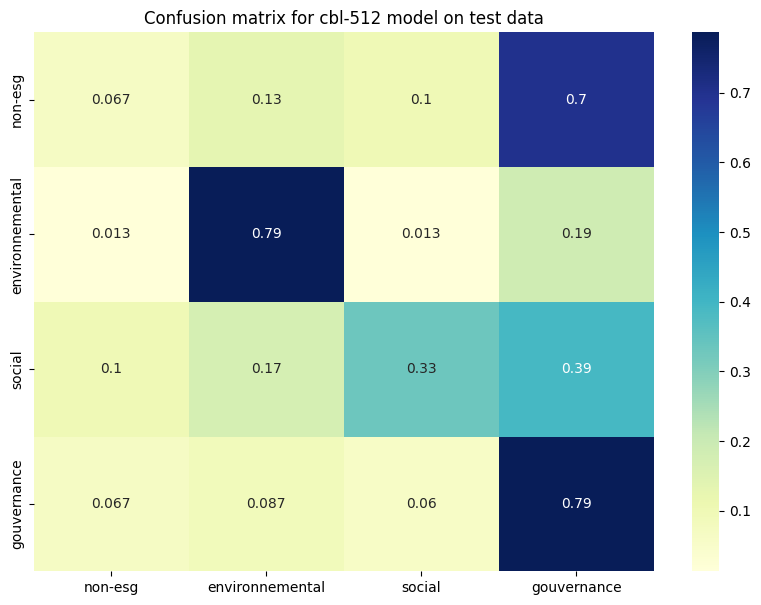

                 precision    recall  f1-score   support

environnemental       0.67      0.79      0.72       150
    gouvernance       0.38      0.79      0.51       150
        non-esg       0.27      0.07      0.11       150
         social       0.66      0.33      0.44       150

       accuracy                           0.49       600
      macro avg       0.49      0.49      0.45       600
   weighted avg       0.49      0.49      0.45       600



In [20]:
print_confusion_matrix(df["esg_category"], cbl_pred, title = "Confusion matrix for cbl-512 model on test data")
report = classification_report(df['esg_category'], cbl_pred, zero_division=0,)
print(report)

## Model Camembert-large-1024 

In [21]:
df_res = utils.predict_df(df_res, model_cbl_1024, tokenizer_large, tokenizer_max_len=1024, return_prediction_only=True, column_name="cbl_1024_pred")
cbl_1024_pred = df_res['cbl_1024_pred'].values

100%|██████████| 600/600 [01:41<00:00,  5.89it/s]


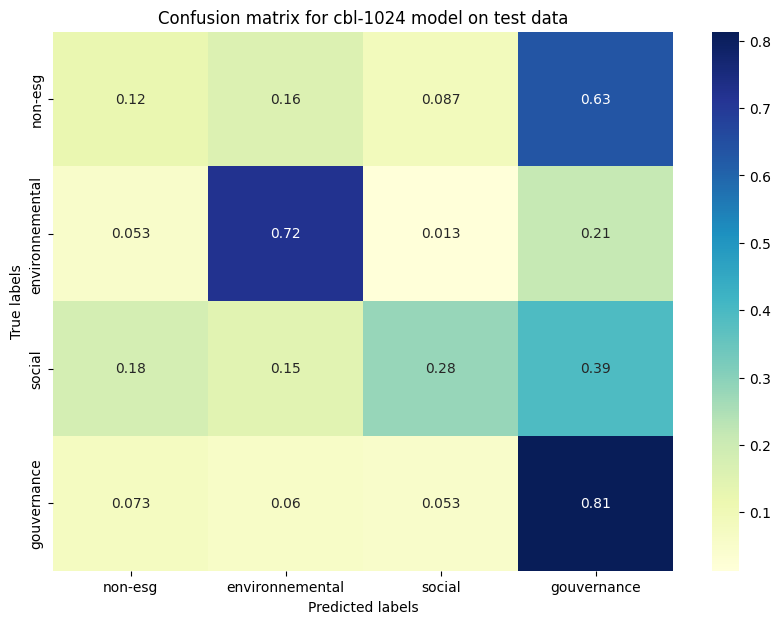

                 precision    recall  f1-score   support

environnemental       0.66      0.72      0.69       150
    gouvernance       0.40      0.81      0.53       150
        non-esg       0.28      0.12      0.17       150
         social       0.65      0.28      0.39       150

       accuracy                           0.48       600
      macro avg       0.50      0.48      0.45       600
   weighted avg       0.50      0.48      0.45       600



In [31]:
print_confusion_matrix(df["esg_category"], cbl_1024_pred, title = "Confusion matrix for cbl-1024 model on test data")
report = classification_report(df['esg_category'], cbl_1024_pred, zero_division=0)
print(report)

# Zero-shot models

Zero-shot classification is performed using the following models:

<!-- add urls -->



In [24]:
ESG_DICT = {
    "environnemental": ["changement climatique", "capital naturel", "pollution et déchets", "Opportunités environnementales"],
    "social": ["capital humain", "responsabilité du produit", "opposition des parties prenantes", "opportunités sociales", "services publiques"],
    "gouvernance": ["gouvernance d'entreprises", "comportement d'entreprises"],
    "non-esg": ["autre","divertissement"]
}
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli")


def predict_sample(sample, candidate_labels, top_k = 3, return_all = False):
    output = classifier(sample, candidate_labels, multi_label=False)
    output_df = pd.DataFrame(output)[["labels", "scores"]][:top_k]
    # find the key from the esg_dict
    output_df["key_label"] = output_df["labels"].apply(lambda x: [key for key, value in ESG_DICT.items() if x in value][0])

    count_dict = {}
    for label in output_df["key_label"]:
        count_dict[label] = count_dict.get(label, 0) + 1

    best_choice = max(count_dict, key=count_dict.get)

    if return_all: return output_df, best_choice

    return best_choice

CANDIDATE_LABELS = list(ESG_DICT.values())
CANDIDATE_LABELS = [item for sublist in CANDIDATE_LABELS for item in sublist]

## MoritzLaurer/mDeBERTa-v3-base-mnli-xnli

In [25]:

df_res['0-shot'] = None
for i,row in tqdm(df_res.iterrows(), total = len(df_res)):
    df_res.at[i,'0-shot'] = predict_sample(row['text'], CANDIDATE_LABELS)
    
debert_base_preds = df_res['0-shot']

100%|██████████| 600/600 [25:35<00:00,  2.56s/it]


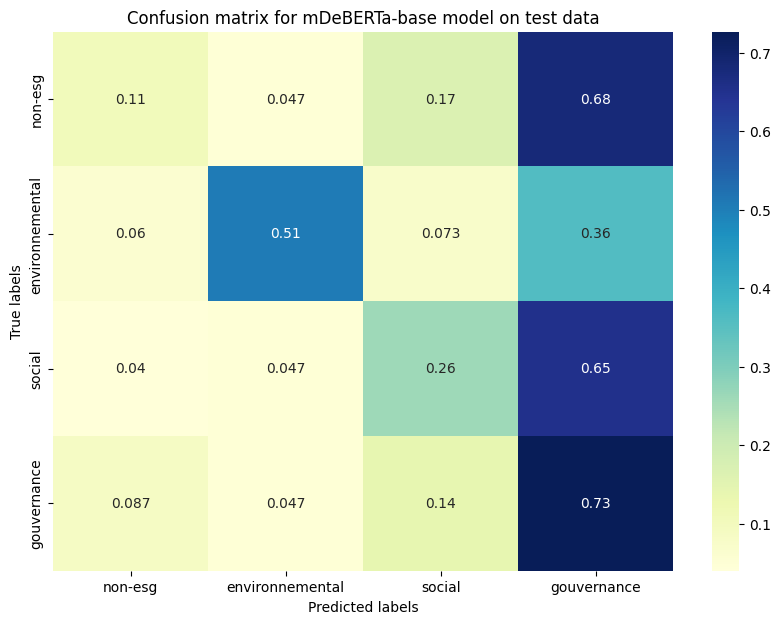

                 precision    recall  f1-score   support

environnemental       0.78      0.51      0.62       150
    gouvernance       0.30      0.73      0.42       150
        non-esg       0.36      0.11      0.16       150
         social       0.41      0.26      0.32       150

       accuracy                           0.40       600
      macro avg       0.46      0.40      0.38       600
   weighted avg       0.46      0.40      0.38       600



In [30]:
print_confusion_matrix(df["esg_category"], debert_base_preds, title = "Confusion matrix for mDeBERTa-base model on test data")
print(classification_report(df['esg_category'], debert_base_preds, zero_division=0))

## MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33

In [36]:
from transformers import pipeline
import warnings
warnings.filterwarnings('ignore')

pipe = pipeline("zero-shot-classification", model="MoritzLaurer/deberta-v3-large-zeroshot-v1.1-all-33")


In [38]:
ESG_DICT_EN = {
    "environnemental": ["climate change", "natural capital", "pollution and waste", "environmental opportunities"],
    "social": ["human capital", "product responsibility", "stakeholder opposition", "social opportunities", "public services"],
    "gouvernance": ["corporate governance", "corporate behavior"],
    "non-esg": ["other","entertainment"]
}

def predict_sample2(sample, candidate_labels, top_k = 3, return_all = False):
    output = classifier(sample, candidate_labels, multi_label=False)
    output_df = pd.DataFrame(output)[["labels", "scores"]][:top_k]
    # find the key from the esg_dict
    output_df["key_label"] = output_df["labels"].apply(lambda x: [key for key, value in ESG_DICT_EN.items() if x in value][0])

    count_dict = {}
    for label in output_df["key_label"]:
        count_dict[label] = count_dict.get(label, 0) + 1

    best_choice = max(count_dict, key=count_dict.get)

    if return_all: return output_df, best_choice

    return best_choice

CANDIDATE_LABELS_EN = list(ESG_DICT_EN.values())
CANDIDATE_LABELS_EN = [item for sublist in CANDIDATE_LABELS_EN for item in sublist]

df_res['0-shot-EN'] = None
for i,row in tqdm(df_res.iterrows(), total = len(df_res)):
    df_res.at[i,'0-shot-EN'] = predict_sample2(row['text_en'], CANDIDATE_LABELS_EN)

debert_large_preds = df_res['0-shot-EN']

100%|██████████| 600/600 [23:16<00:00,  2.33s/it]


In [39]:
df_res.to_csv("./ESGBert_test_data_preds.csv", index = False)

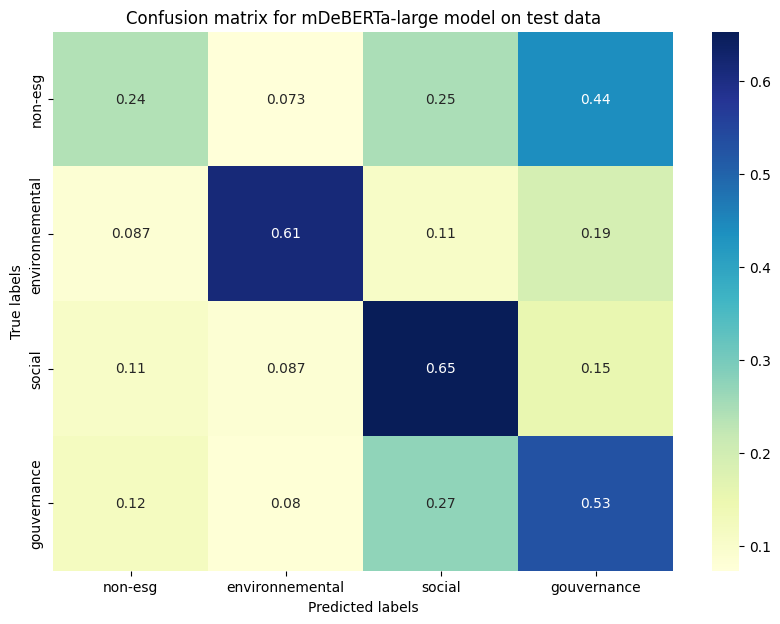

                 precision    recall  f1-score   support

environnemental       0.72      0.61      0.66       150
    gouvernance       0.40      0.53      0.46       150
        non-esg       0.43      0.24      0.31       150
         social       0.51      0.65      0.57       150

       accuracy                           0.51       600
      macro avg       0.52      0.51      0.50       600
   weighted avg       0.52      0.51      0.50       600



In [40]:
print_confusion_matrix(df["esg_category"], debert_large_preds, title = "Confusion matrix for mDeBERTa-large model on test data")
print(classification_report(df['esg_category'], debert_large_preds, zero_division=0))

# Algorithm to combine the models above and get a final prediction

> COMBINE THE RESULTS TO VIEW THE RESULTS TOO

ideas:
- add weights to each models depending on their results. some models may havem ore weights than other

In [4]:
df_res = pd.read_csv("./ESGBert_test_data_preds.csv")
df_res.head()

,text_en,esg_category,text,cbl_pred,cbl_1024_pred,0-shot,0-shot-EN
0,We have a dedicated team who manage a portfoli...,social,Nous avons une équipe dévouée qui gère un port...,gouvernance,gouvernance,gouvernance,environnemental
1,A listed entity should disclose whether it has...,social,Une entité inscrite sur la liste devrait indiq...,environnemental,environnemental,gouvernance,environnemental
2,Our suppliers' activities support our overall ...,social,Les activités de nos fournisseurs appuient not...,gouvernance,gouvernance,gouvernance,gouvernance
3,This year we raised the bar on our environment...,social,"Cette année, nous avons relevé la barre de nos...",environnemental,environnemental,social,social
4,"the BGC’s AdTech forum, which includes a parti...",social,"le forum AdTech de BGC, qui comprend un accent...",gouvernance,gouvernance,social,social


In [5]:
weights = [
    [0.25, 0.4,0.15,0.2], # cbl
    [0.25,0.2,0.15,0.4], # cbl-1024
    [0.25,0.2,0.15,0.2], # debert-base
    [0.25,0.2,0.55,0.2] # debert-large
]

# order of weights: non-esg, environnemental, social, gouvernance


df_res['agg_pred'] = None
for i,row in tqdm(df_res.iterrows(), total = len(df_res)):
    cbl_pred = row['cbl_pred']
    cbl_1024_pred = row['cbl_1024_pred']
    debert_base_pred = row['0-shot']
    debert_large_pred = row['0-shot-EN']
    
    preds = [cbl_pred, cbl_1024_pred, debert_base_pred, debert_large_pred]
    
    pred_dict = {
        "non-esg": 0,
        "environnemental": 0,
        "social": 0,
        "gouvernance": 0
    }
    
    pred_dict[cbl_pred] += weights[0][list(pred_dict.keys()).index(cbl_pred)]
    pred_dict[cbl_1024_pred] += weights[1][list(pred_dict.keys()).index(cbl_1024_pred)]
    pred_dict[debert_base_pred] += weights[2][list(pred_dict.keys()).index(debert_base_pred)]
    pred_dict[debert_large_pred] += weights[3][list(pred_dict.keys()).index(debert_large_pred)]
    
    best_pred = max(pred_dict, key=pred_dict.get)
    df_res.at[i,'agg_pred'] = best_pred
    
agg_preds = df_res['agg_pred']

    


100%|██████████| 600/600 [00:00<00:00, 13624.95it/s]


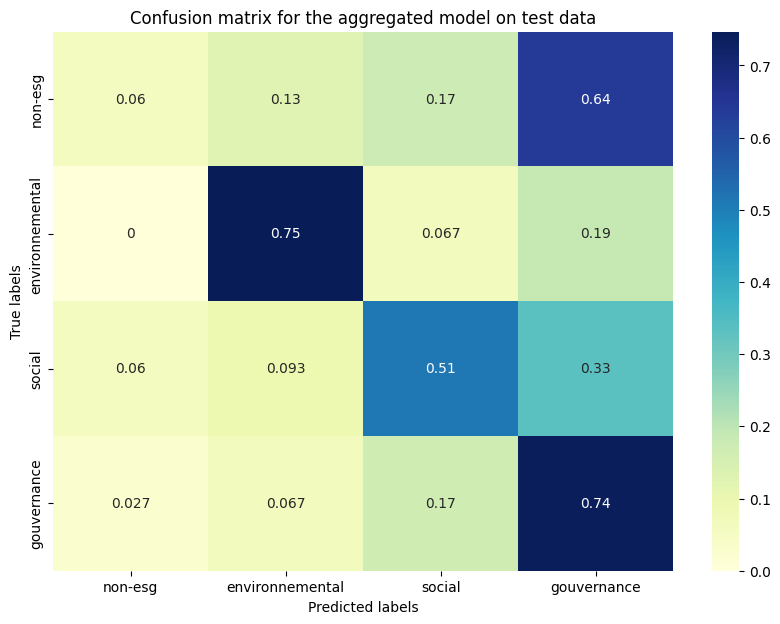

                 precision    recall  f1-score   support

environnemental       0.72      0.75      0.73       150
    gouvernance       0.39      0.74      0.51       150
        non-esg       0.41      0.06      0.10       150
         social       0.56      0.51      0.53       150

       accuracy                           0.52       600
      macro avg       0.52      0.52      0.47       600
   weighted avg       0.52      0.52      0.47       600



In [7]:
print_confusion_matrix(df_res["esg_category"], agg_preds, title = "Confusion matrix for the aggregated model on test data")
print(classification_report(df_res['esg_category'], agg_preds, zero_division=0))
